<a href="https://colab.research.google.com/github/Deleon57/EDAR-Data/blob/main/KNN123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This code sets up all the tools needed for your stock prediction project. It imports libraries to work with data (numpy, pandas) and to fetch stock prices from Yahoo Finance (yfinance). It brings in machine learning functions from scikit-learn to build a K-Nearest Neighbours model, scale the data, split it into time-based training and testing sets, and fine-tune the model. It also includes functions to measure performance using accuracy, precision, recall, F1-score, and confusion matrices. Lastly, it imports plotting tools to create graphs and sets a default figure size for visualisations.

In [13]:
import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 5)

#In this section, I set the stock I want to analyse to Gold Fields (GFI.JO) and chose my data period from 1 March 2013 to 28 February 2024. I set the prediction horizon to one day, meaning I want to predict the next day’s movement. I defined a threshold of 0.5%, so the model will predict a class of 1 if the next day’s return is greater than 0.5%. Finally, I set my backtest period to start on 1 January 2024 so that the model is tested on the most recent data after training on the earlier period.


In [14]:
TICKER = "GFI.JO"
START  = "2013-03-01"
END    = "2024-02-28"

# Label: predict if NEXT day's return > +threshold (directional threshold)
HORIZON_DAYS = 1
THRESHOLD = 0.005   # 0.5% next-day move for class=1; set to 0 for simple up/down

# Backtest: final holdout window (chronological)
# With your END date, this will likely be ~2024-01-01 onward
TEST_START = "2024-01-01"

#Here, I downloaded historical stock data for Gold Fields from Yahoo Finance using the date range I set earlier. I kept only the essential columns, Open, High, Low, Close, and Volume and removed any missing values. Finally, I displayed the last three rows of the dataset to quickly check the most recent data points.

In [15]:
df = yf.download(TICKER, start=START, end=END, auto_adjust=False)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
df.tail(3)

[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO
Date,,,,,
2024-02-23,23951.0,24765.0,23750.0,24300.0,2786706
2024-02-26,24650.0,24827.0,23688.0,23800.0,2276971
2024-02-27,23865.0,24568.0,23865.0,24132.0,1523152


#Here, I selected the closing prices from the dataset and calculated the daily percentage return (ret_1d). I then created rolling statistics to use as features for the model. This included simple moving averages over 10, 20, and 50 days, exponential moving averages over 12 and 26 days, and volatility measures calculated as the standard deviation of returns over 10 and 20 days. These features help capture trends and patterns in the stock’s price movement.

In [24]:
px = df['Close']

# Basic returns
df['ret_1d'] = px.pct_change(1)

# Rolling stats
df['sma_10'] = px.rolling(10).mean()
df['sma_20'] = px.rolling(20).mean()
df['sma_50'] = px.rolling(50).mean()
df['ema_12'] = px.ewm(span=12, adjust=False).mean()
df['ema_26'] = px.ewm(span=26, adjust=False).mean()
df['vol_10'] = df['ret_1d'].rolling(10).std()
df['vol_20'] = df['ret_1d'].rolling(20).std()

#Here, I calculated the 14-day Relative Strength Index (RSI) for the stock. First, I found the daily price changes (delta), then separated the positive changes (gain) and negative changes (loss). I averaged each over a 14-day rolling window, calculated the relative strength (rs) as gains divided by losses, and finally applied the RSI formula to scale it between 0 and 100. This indicator helps measure whether the stock is overbought or oversold.

In [25]:
# RSI (14)
delta = px.diff()
gain = (delta.clip(lower=0)).rolling(14).mean()
loss = (-delta.clip(upper=0)).rolling(14).mean()
rs = gain / (loss.replace(0, np.nan))
df['rsi_14'] = 100 - (100 / (1 + rs))

#Here, I calculated the Moving Average Convergence Divergence (MACD) and its signal line. The MACD is found by subtracting the 26-day exponential moving average (EMA) from the 12-day EMA, which highlights short-term momentum compared to longer-term trends. The signal line is then calculated as a 9-day EMA of the MACD itself, which is often used to identify potential buy or sell signals when it crosses the MACD.

In [26]:
# MACD and signal
df['macd'] = df['ema_12'] - df['ema_26']
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()


#Here, I calculated the Bollinger %B indicator using a 20-day period. First, I computed the 20-day moving average (mb) and standard deviation (sd). I then set the upper and lower Bollinger Bands as two standard deviations above and below the moving average. Finally, I calculated %B, which measures where the current price sits relative to these bands — a value near 1 means the price is close to the upper band, while a value near 0 means it’s close to the lower band.

In [27]:
# Bollinger %B (20, 2)
mb = px.rolling(20).mean()
sd = px.rolling(20).std()
upper = mb + 2*sd
lower = mb - 2*sd
df['bb_pctB'] = (px - lower) / (upper - lower)

3Here, I created momentum features to capture short-term and medium-term price changes. The 5-day momentum (mom_5) measures the percentage change between the current price and the price 5 days ago, while the 10-day momentum (mom_10) does the same over a 10-day period. These features help indicate the strength and direction of recent price trends.

In [28]:
# Momentum features
df['mom_5'] = px / px.shift(5) - 1
df['mom_10'] = px / px.shift(10) - 1

#Here, I created a volume feature (vol_z) that measures how the current trading volume compares to its 20-day average, scaled by its 20-day standard deviation. This is essentially a z-score for volume, showing whether current volume is unusually high or low. After calculating it, I removed any rows with missing values and displayed the first three rows of the updated dataset.

In [29]:
# Volume features
df['vol_z'] = (df['Volume'] - df['Volume'].rolling(20).mean()) / (df['Volume'].rolling(20).std())

df.dropna(inplace=True)
df.head(3)

Price,Open,High,Low,Close,Volume,ret_1d,sma_10,sma_20,sma_50,ema_12,...,close_lag_1,ret_lag_1,close_lag_2,ret_lag_2,close_lag_3,ret_lag_3,close_lag_5,ret_lag_5,fwd_ret,y
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,


#Here, I created lag features to include past values of the stock’s closing price and daily returns as inputs for the model. For each lag in the list [1, 2, 3, 5], I shifted the data to capture what the close price and return were 1, 2, 3, and 5 days ago. These lagged features help the model learn patterns from recent historical movements. After creating them, I removed any rows with missing values and displayed the first three rows of the updated dataset.

In [17]:
LAGS = [1, 2, 3, 5]

for l in LAGS:
    df[f'close_lag_{l}'] = df['Close'].shift(l)
    df[f'ret_lag_{l}']   = df['ret_1d'].shift(l)

df.dropna(inplace=True)
df.head(3)

Price,Open,High,Low,Close,Volume,ret_1d,sma_10,sma_20,sma_50,ema_12,...,mom_10,vol_z,close_lag_1,ret_lag_1,close_lag_2,ret_lag_2,close_lag_3,ret_lag_3,close_lag_5,ret_lag_5
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-16,5750.0,5864.0,5510.0,5864.0,5389679,0.023029,6090.7,6280.10,6631.94,6091.993545,...,-0.095062,0.186218,5732.0,-0.043870,5995.0,-0.005144,6026.0,0.002662,6264.0,0.029417
2013-05-17,5652.0,5790.0,5534.0,5534.0,3389361,-0.056276,6004.4,6251.90,6597.62,6006.148384,...,-0.134907,-0.615124,5864.0,0.023029,5732.0,-0.043870,5995.0,-0.005144,6010.0,-0.040549
2013-05-20,5467.0,5467.0,5187.0,5415.0,6061573,-0.021503,5907.8,6210.15,6560.72,5915.202479,...,-0.151387,0.548202,5534.0,-0.056276,5864.0,0.023029,5732.0,-0.043870,6026.0,0.002662


#Here, I calculated the forward return (fwd_ret) over the prediction horizon, which measures the percentage change from today’s closing price to the closing price in the future (in this case, the next day). I then created the binary target variable y, which is 1 if the forward return is greater than the set threshold and 0 otherwise. Finally, I removed the last few rows with missing values caused by the shifting process and displayed the last five rows of the forward return and target columns.

In [18]:
# Forward return over the chosen horizon
df['fwd_ret'] = df['Close'].shift(-HORIZON_DAYS) / df['Close'] - 1

# Binary target
df['y'] = (df['fwd_ret'] > THRESHOLD).astype(int)

# Drop the very last rows that have NaN fwd_ret due to shift(-HORIZON_DAYS)
df = df.iloc[:-HORIZON_DAYS, :]

df[['fwd_ret','y']].tail(5)

Price,fwd_ret,y
Ticker,,
Date,,
2024-02-20,-0.036858,0
2024-02-21,-0.047146,0
2024-02-22,0.006128,1
2024-02-23,-0.020576,0
2024-02-26,0.013950,1


#Here, I created my feature set and target for the model. The FEATURES list contains all the technical indicators, rolling statistics, momentum, volume measures, and lagged variables I calculated earlier. I then stored these in X for the model inputs and used the binary target y as the output variable. Lastly, I printed the shape of the dataset to see how many rows and columns I have, and I checked the class balance to understand the proportion of 0s and 1s in the target variable.

In [19]:
FEATURES = [
    'ret_1d','sma_10','sma_20','sma_50','ema_12','ema_26','vol_10','vol_20',
    'rsi_14','macd','macd_signal','bb_pctB','mom_5','mom_10','vol_z'
] + [f'close_lag_{l}' for l in LAGS] + [f'ret_lag_{l}' for l in LAGS]

X = df[FEATURES].copy()
y = df['y'].copy()

print("Data shape:", X.shape)
print("Class balance (0/1):")
print(y.value_counts(normalize=True).rename('share'))

Data shape: (2742, 23)
Class balance (0/1):
y
0    0.591904
1    0.408096
Name: share, dtype: float64


#Here, I split the data into training and testing sets based on time. All rows before the TEST_START date go into the training set, and all rows from TEST_START onward go into the test set. This ensures the model is trained only on past data and tested on future data, avoiding look-ahead bias. I then printed the date ranges and the number of rows for both sets to confirm the split.

In [20]:
# Chronological split: train up to TEST_START-1, test from TEST_START
X_train = X.loc[:TEST_START].iloc[:-1]  # everything strictly before TEST_START
y_train = y.loc[X_train.index]

X_test  = X.loc[TEST_START:]
y_test  = y.loc[X_test.index]

print("Train:", X_train.index.min(), "→", X_train.index.max(), "n=", len(X_train))
print("Test: ", X_test.index.min(),  "→", X_test.index.max(),  "n=", len(X_test))

Train: 2013-05-16 00:00:00 → 2023-12-28 00:00:00 n= 2701
Test:  2024-01-02 00:00:00 → 2024-02-26 00:00:00 n= 40


#Here, I built a machine learning pipeline that first scales the features (StandardScaler) and then applies the K-Nearest Neighbours classifier. I set up a parameter grid to test different numbers of neighbours, weighting methods, and distance metrics. Using TimeSeriesSplit for 5 folds, I ran a grid search to find the best combination of parameters, optimising for the F1-score to balance precision and recall. Finally, I trained the model on the training set and printed the best parameters and the best cross-validation F1-score.

In [21]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Search a small, sensible grid (kept compact to be fast)
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # Manhattan vs Euclidean
}

tscv = TimeSeriesSplit(n_splits=5)

# Optimise for F1 to balance precision/recall
gcv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring='f1',
    n_jobs=-1,
    refit=True
)

gcv.fit(X_train, y_train)

print("Best params:", gcv.best_params_)
print("Best CV F1:", round(gcv.best_score_, 4))

Best params: {'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'uniform'}
Best CV F1: 0.3505


#I took the best KNN model found in cross‑validation and used it to predict on the test period. Then I evaluated those predictions with common classification metrics: accuracy (overall correctness), precision (how many predicted 1s were truly 1s), recall (how many true 1s I caught), and the F1‑score (a balance of precision and recall). I also printed a detailed classification report and drew a confusion matrix heatmap to show counts of correct vs incorrect predictions for each class, adding the numbers on the chart so it’s easy to read.

Holdout metrics:
Accuracy: 0.625
Precision: 0.4667
Recall: 0.5
F1: 0.4828

              precision    recall  f1-score   support

           0     0.7200    0.6923    0.7059        26
           1     0.4667    0.5000    0.4828        14

    accuracy                         0.6250        40
   macro avg     0.5933    0.5962    0.5943        40
weighted avg     0.6313    0.6250    0.6278        40



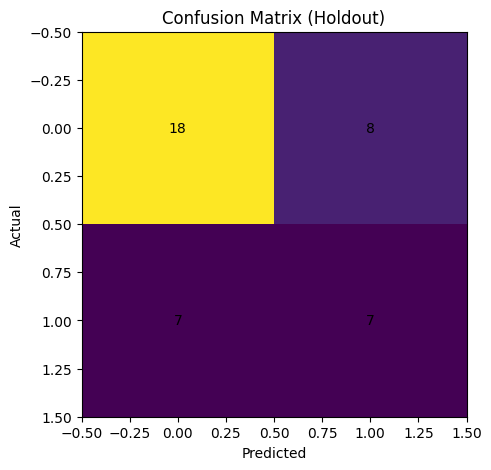

In [22]:
best_model = gcv.best_estimator_

y_pred = best_model.predict(X_test)

print("Holdout metrics:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("F1:", round(f1_score(y_test, y_pred), 4))
print()
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm)
plt.title("Confusion Matrix (Holdout)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.show()